import modules

In [ ]:
%load_ext tensorboard

In [82]:
#Final yes

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner as kt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import haha

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)
log_dir = "../../assets/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Pre Modelling

Load Dataset


In [83]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

Rescale Data

In [84]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

Train Validation Test split

In [85]:
#Train Validation Test split
#Train[:70%] Validation[70%:80%] Test[80%:]
train=df[:int(0.7*15*30)]; validation=df[int(0.7*15*30):int(0.8*15*30)]; test=df[int(0.8*15*30):]

#Plotting

Text(0.5, 1.0, 'Train, validation, & test')

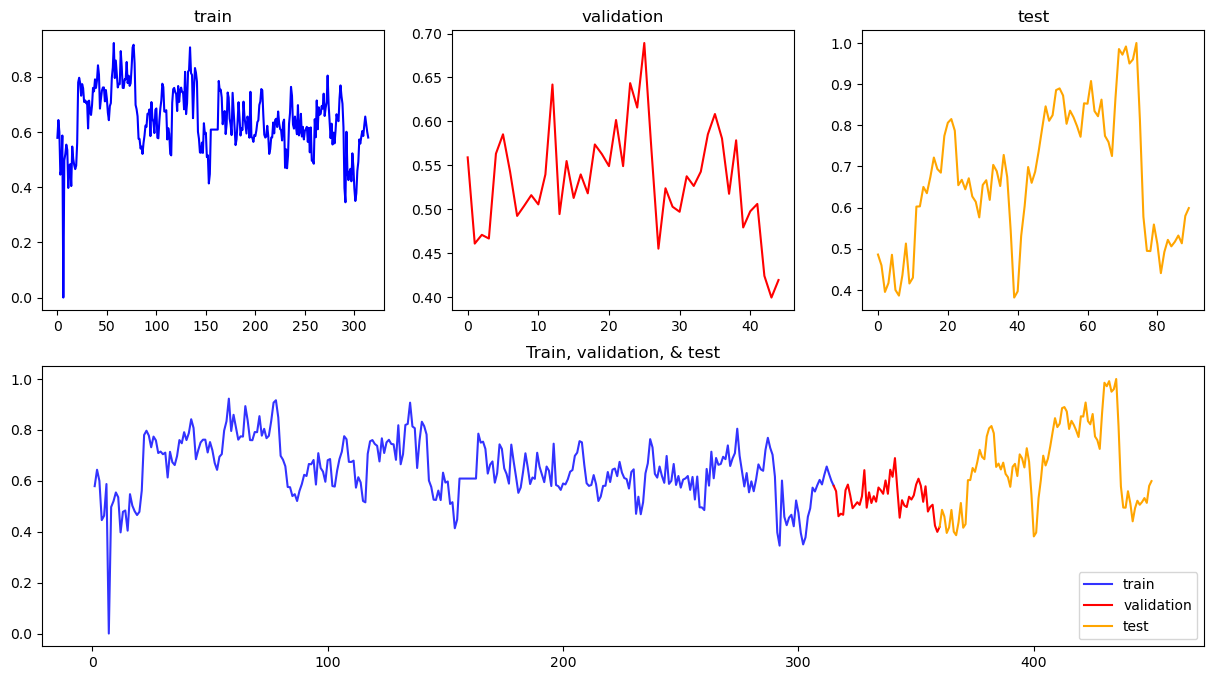

In [86]:
fig =plt.figure(figsize=(15,8))
ax=fig.add_subplot(2,3,1)
ax.plot(train, c="blue")
ax.set_title("train")
ax=fig.add_subplot(2,3,2)
ax.plot(validation, c="red")
ax.set_title("validation")
ax=fig.add_subplot(2,3,3)
ax.plot(test, c="orange")
ax.set_title("test")

ax=fig.add_subplot(2,1,2)
temp=np.array(list(map(list, zip(train.flatten(), range(1,len(train)+1)))))
ax.plot(temp[:,1], temp[:,0], c="blue", label="train", alpha=0.8)

temp=np.array(list(map(list, zip(validation.flatten(), range(len(train)+1,len(train)+len(validation)+1)))))
temp=np.concatenate(([[train.flatten()[-1],len(train)]], temp),axis=0)
ax.plot(temp[:,1], temp[:,0], c="red", label="validation")

temp1=np.array(list(map(list, zip(test.flatten(), range(int(temp[-1][-1])+1, len(df)+1)))))
temp=np.concatenate(([temp[-1]], temp1),axis=0)
ax.plot(temp[:,1], temp[:,0], c="orange", label="test")


ax.legend(loc="lower right")
ax.set_title("Train, validation, & test")

In [87]:
# reshape into X=t and Y=t+1
t=20
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)
validationx, validationy = haha.lag(validation, t)

In [93]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, features, time steps]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
validationx = np.reshape(validationx, (validationx.shape[0], validationx.shape[1], 1))

## Modelling and fitting

declare necessities 

In [90]:
#metrics
def r2scoremetrics(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - (SS_res/SS_tot) )                              #Doesn't get used due to a misleading val_score during training


#callback
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]
    
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)
        
def theplot(history):
    fig = plt.figure(figsize=(15,13))
    ax=fig.add_subplot(3,2,1)
    ax.plot(history.history["mean_absolute_error"], label="mean_absolute_error", c="blue")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.1)
    
    ax=fig.add_subplot(3,2,2)
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,20)
    
    ax=fig.add_subplot(3,1,2)
    ax.plot(history.history["loss"], label="mean_squared_error", c="blue")
    ax.plot(history.history["val_loss"], label="val_mean_squared_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.01)
    ax.set_xlabel("epochs")
    ax.set_ylabel("MSE")
    
    ax=fig.add_subplot(3,1,3)
    ax.plot(history.history["mean_absolute_percentage_error"], label="mean_absolute_percentage_error", c="blue")
    ax.legend(loc="lower right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.set_ylim(0,30)

Model

In [91]:
batch_size=32

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st layer
        keras.layers.LSTM(8),                                                              #2nd layer
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
    return model

#Fitting

In [ ]:
model=getmodel_compile()

thehistory=model.fit(trainX, trainY, epochs=1000, validation_data=(validationx, validationy), 
                     batch_size=batch_size, verbose=0,
                     callbacks=[tensorboardlogger(), SelectiveProgbarLogger(verbose=1, epoch_interval=10)])

Check fitting metrics history by plot | Nt: y_true, y_pred haven't been denormalized

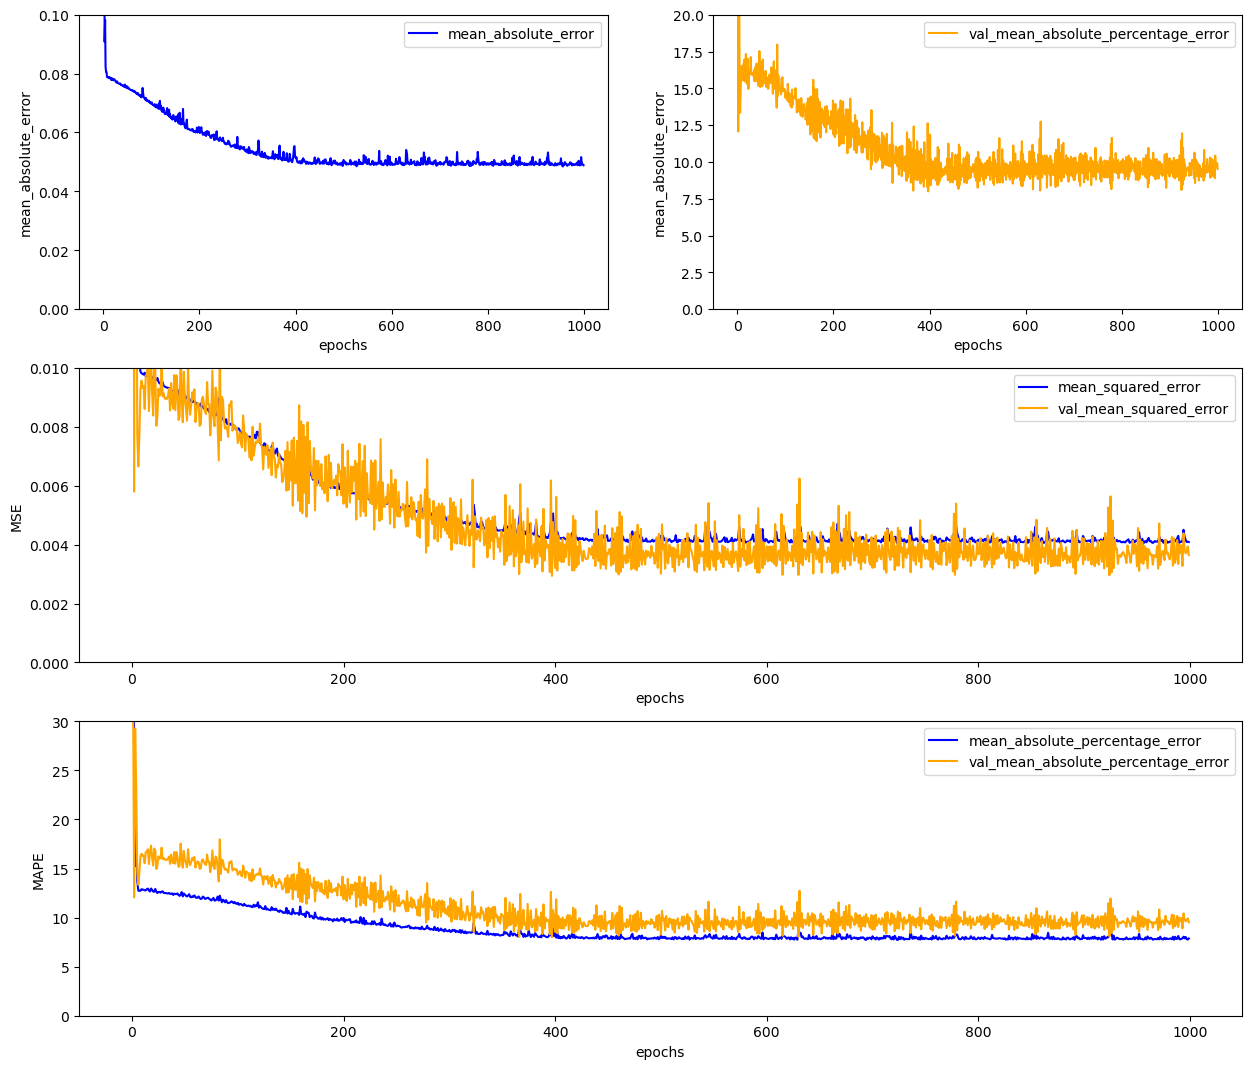

In [28]:
theplot(thehistory)

In [ ]:
model=keras.models.load_model("../../assets/newtestt20.keras",  custom_objects={"r2scoremetrics": r2scoremetrics})

Get the predicted of train and test

In [94]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size)
validationpredict = model.predict(validationx, batch_size=batch_size)

1/1 [==============================] - 0s 32ms/step


In [95]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
validationpredict = scaler.inverse_transform(validationpredict).flatten()


validationy = scaler.inverse_transform([validationy]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

Metrics of the predicted by the model

In [96]:
# Evaluation metrics
import math
'''
print("Train")
print(f'RMSE    :   {math.sqrt(mean_squared_error(trainY,trainPredict))}')
print(f'MSE     :   {mean_squared_error(trainY,trainPredict)}')
print(f'MAE     :   {mean_absolute_error(trainY,trainPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(trainY,trainPredict)}')
print(f'R2score :   {r2_score(trainY, trainPredict)}')


print("\nTest")
print(f'RMSE    :   {math.sqrt(mean_squared_error(testY,testPredict))}')
print(f'MSE     :   {mean_squared_error(testY,testPredict)}')
print(f'MAE     :   {mean_absolute_error(testY,testPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(testY,testPredict)}')
print(f'R2score :   {r2_score(testY, testPredict)}')
'''

trainmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(trainY,trainPredict)),
    mean_squared_error(trainY,trainPredict),
    mean_absolute_error(trainY,trainPredict),
    mean_absolute_percentage_error(trainY,trainPredict),
    r2_score(trainY, trainPredict)
],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

validationmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(validationy, validationpredict)),
    mean_squared_error(validationy, validationpredict),
    mean_absolute_error(validationy, validationpredict),
    mean_absolute_percentage_error(validationy, validationpredict),
    r2_score(validationy, validationpredict)
], index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

print("Train")
print(trainmetrics)

print("Validation")
print(validationmetrics)

Train
                0
RMSE     0.882623
MSE      0.779023
MAE      0.693983
MAPE     0.003639
R2score  0.988621
Validation
                 0
RMSE      7.736825
MSE      59.858454
MAE       6.351775
MAPE      0.035332
R2score  -1.180692


In [97]:
#Renormalize
validationy = scaler.transform(validationy.reshape(-1,1))
trainY = scaler.transform(trainY.reshape(-1,1))

Predicted vs actual

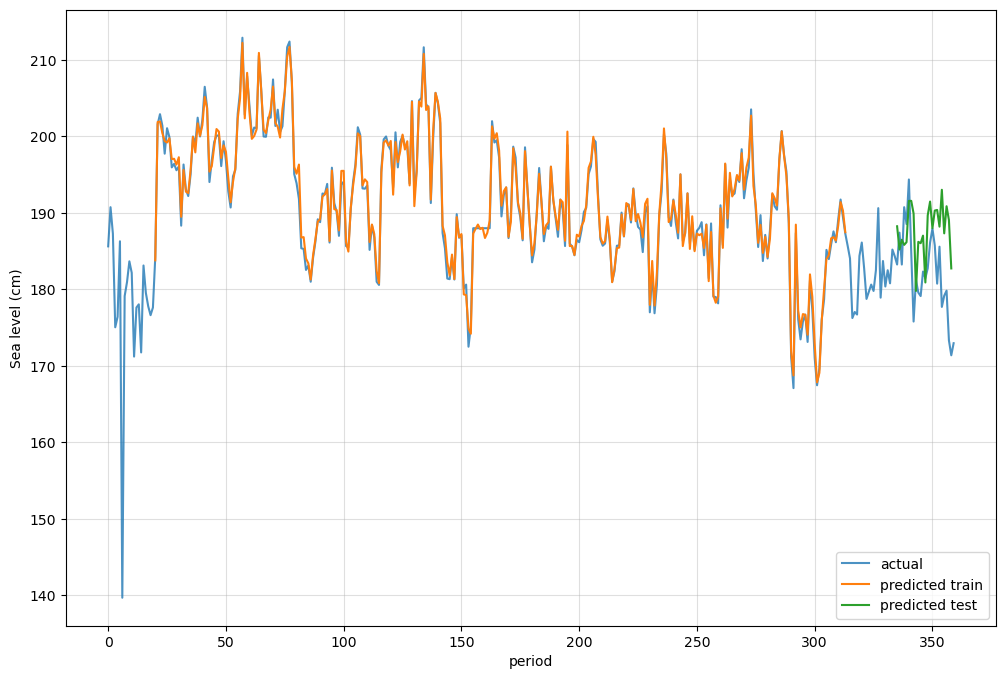

In [81]:
haha.plot_predicted(scaler.inverse_transform(df[:int(0.8*15*30)]), trainPredict.reshape(-1,1), validationpredict.reshape(-1,1), t)

In [41]:
model.save("../../assets/newtestt20.keras")

## Getting the best model

Declare model builder

In [42]:
def model_builder(hp):
    
    #declare tuning
    firsthidden=hp.Int('1st_layer',min_value=32,max_value=512,step=32)
    secondhidden=hp.Int('2nd_layer',min_value=32,max_value=512,step=32)
    thedropout=hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)
    outputactivation=hp.Choice('output_activation',values=['relu', 'sigmoid'],default='relu')
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential()

    model.add(keras.layers.LSTM(firsthidden, input_shape=(t, 1), return_sequences=True))

    model.add(keras.layers.LSTM(secondhidden))
    
    model.add(keras.layers.Dropout(thedropout))
    
    model.add(keras.layers.Dense(1, activation=outputactivation))
   
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=hp_lr)
                  ,metrics = ['mse'])
    
    return model

Getting tuning methode

In [43]:
currenttime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
thetuner=kt.Hyperband(model_builder, objective="mse",                       #Finding the best mse
                      max_epochs=30,
                      factor=2,
                      directory='../../assets/',  
                      project_name=currenttime)

Initiate and get best model by paramaters

In [44]:
thetuner.search(trainX, trainY, epochs=100, validation_data=(validationx, validationy), batch_size=batch_size)

best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 92 Complete [00h 00m 16s]
mse: 0.00690413499251008

Best mse So Far: 0.005718222353607416
Total elapsed time: 00h 14m 07s


Search for the best epoch of the best model

In [ ]:
#Build model with the most optimal hyperparameters and search for the most optimum epoch
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(trainX, trainY, epochs=1000, validation_data=(validationx, validationy), batch_size=batch_size)

val_mse_per_epoch = process.history['val_mse']
best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [46]:
bestepoch=sorted(list(enumerate(process.history['val_loss'])), key=lambda x:x[1])[:5]
bestepoch               #best epochs range at 50-90

[(54, 0.0030781140085309744),
 (38, 0.0031742118299007416),
 (138, 0.0031922764610499144),
 (44, 0.003197446698322892),
 (75, 0.0032149609178304672)]

In [ ]:
#build model with most optimum epoch
thesupasupabestmodel = thetuner.hypermodel.build(best_hps[0])

# Retrain the model
thesupasupabestmodel.fit(trainX, trainY, epochs=54, validation_data=(validationx, validationy), batch_size=batch_size)

In [ ]:
thesupasupabestmodel=keras.models.load_model("../../assets/anotherbestmodelt20.keras")

Getting the best model metrics

In [113]:
#predict
trainPredict = thesupasupabestmodel.predict(trainX, batch_size=batch_size)
validationpredict = thesupasupabestmodel.predict(validationx, batch_size=batch_size)

1/1 [==============================] - 0s 26ms/step


In [114]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
validationpredict = scaler.inverse_transform(validationpredict).flatten()


validationy = scaler.inverse_transform(validationy.reshape(-1,1)).flatten()
trainY = scaler.inverse_transform(trainY.reshape(-1,1)).flatten()

In [116]:
# Evaluation metrics
bestmodeltrainmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(trainY,trainPredict)),
    mean_squared_error(trainY,trainPredict),
    mean_absolute_error(trainY,trainPredict),
    mean_absolute_percentage_error(trainY,trainPredict),
    r2_score(trainY, trainPredict)
],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

bestmodelvalmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(validationy, validationpredict)),
    mean_squared_error(validationy, validationpredict),
    mean_absolute_error(validationy, validationpredict),
    mean_absolute_percentage_error(validationy, validationpredict),
    r2_score(validationy, validationpredict)],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

print("Train")
print(bestmodeltrainmetrics)

print("\nValidation")
print(bestmodelvalmetrics)

Train
                 0
RMSE      5.035089
MSE      25.352123
MAE       3.831302
MAPE      0.020084
R2score   0.629683

Validation
                 0
RMSE      4.973478
MSE      24.735486
MAE       3.939796
MAPE      0.021828
R2score   0.098866


In [117]:
#Renormalize
trainY = scaler.transform(trainY.reshape(-1,1))
validationy = scaler.transform(validationy.reshape(-1,1))

In [109]:
len(scaler.inverse_transform(df[:int(0.8*15*30)]))

360

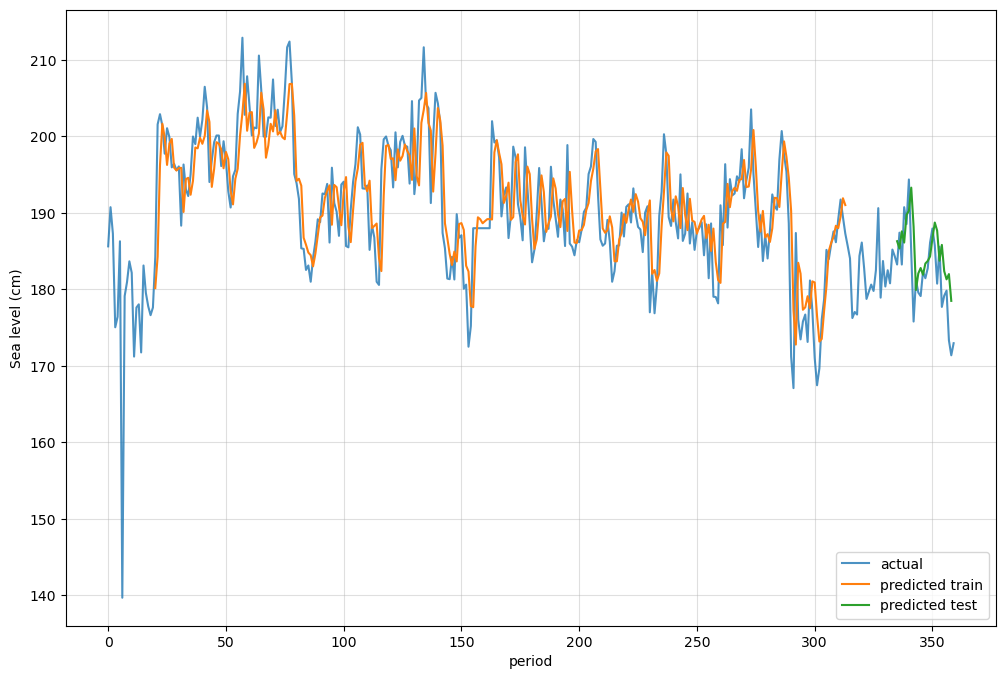

In [118]:
haha.plot_predicted(scaler.inverse_transform(df[:int(0.8*15*30)]), trainPredict.reshape(-1,1), validationpredict.reshape(-1,1), t)

In [119]:
thesupasupabestmodel.save("../../assets/anotherbestmodelt20.keras")

## Comparison

In [120]:
Traincompared=pd.concat((trainmetrics, bestmodeltrainmetrics), axis=1)
valcompared=pd.concat((validationmetrics, bestmodelvalmetrics), axis=1)
Traincompared.columns=["1st model", "Best model"]
valcompared.columns=["1st model", "Best model"]

print("Train")
print(Traincompared)

print("\validation")
print(valcompared)

Train
         1st model  Best model
RMSE      0.882623    5.035089
MSE       0.779023   25.352123
MAE       0.693983    3.831302
MAPE      0.003639    0.020084
R2score   0.988621    0.629683
alidation
         1st model  Best model
RMSE      7.736825    4.973478
MSE      59.858454   24.735486
MAE       6.351775    3.939796
MAPE      0.035332    0.021828
R2score  -1.180692    0.098866


## Forecasting

Get the next 90 days (Forecasting test data)

In [123]:
def forecast(predictedday, model, testdata, t):
    forecasted=[]
    theinput=testdata[-t:]

    firstinput = theinput.reshape((1, t,1))
    temppredicted = model.predict(firstinput, verbose=0)
    theinput=np.concatenate((theinput, temppredicted), axis=0)
    forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
    
    for i in range(1,predictedday):
        theinput=theinput[1:].flatten().reshape(1,t,1)
        temppredicted=model.predict(theinput, verbose=0)
        theinput=np.concatenate((theinput.reshape(-1,1), temppredicted), axis=0)
        forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
        
    return np.array(forecasted)

iwannaforecast=90
z=forecast(predictedday=iwannaforecast, model=thesupasupabestmodel, testdata=validation, t=t)

Plot Latest data n=20 vs next 90 forecasted

Text(0.5, 0, 'Period')

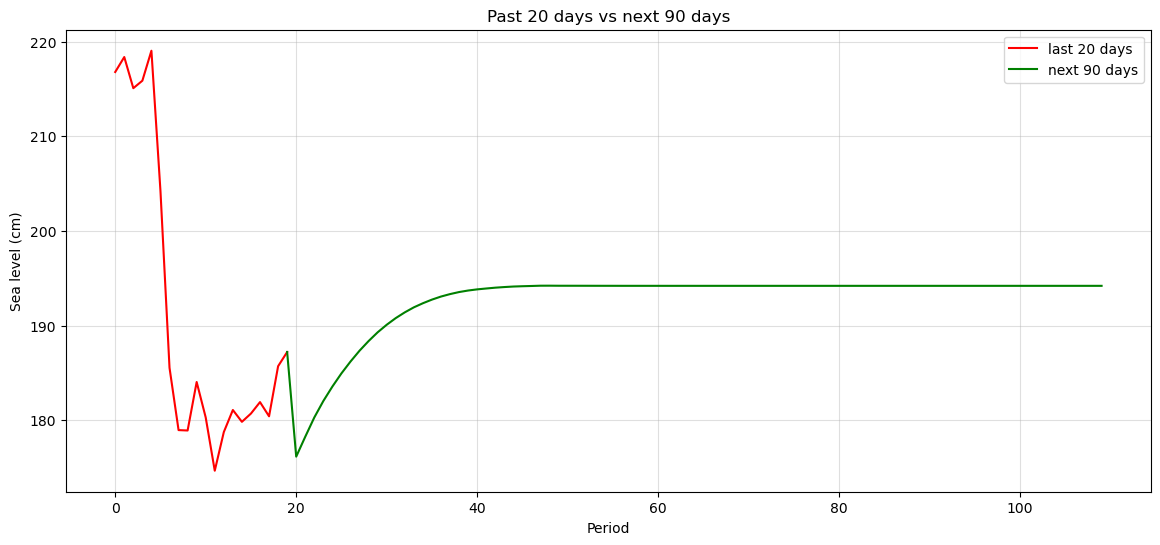

In [166]:
temp=np.array([None for i in range(t+iwannaforecast)])
temp[t-1]=scaler.inverse_transform(test)[len(test)-1][0]
temp[t:]=z.flatten()

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.plot(scaler.inverse_transform(test[-t:]), c="red", label="last 20 days")
ax.plot(temp, c="green", label="next 90 days")
ax.grid(alpha=0.4)
ax.set_title("Past 20 days vs next 90 days")
ax.legend(loc="upper right")
ax.set_ylabel("Sea level (cm)")
ax.set_xlabel("Period")

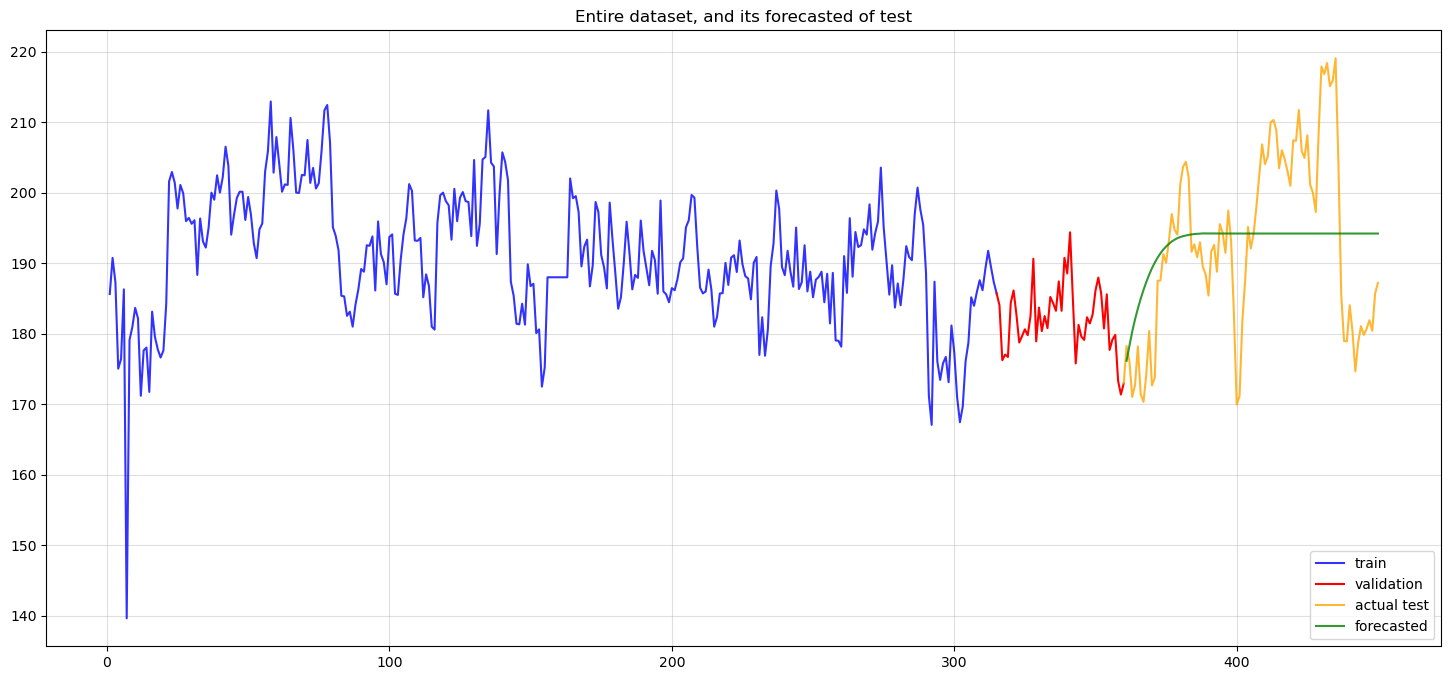

In [185]:
fig, ax =plt.subplots(1,1, figsize=(18,8))
temp=np.array(list(map(list, zip(scaler.inverse_transform(train).flatten(), range(1,len(train)+1)))))
ax.plot(temp[:,1], temp[:,0], c="blue", label="train", alpha=0.8)

temp=np.array(list(map(list, zip(scaler.inverse_transform(validation).flatten(), range(len(train)+1,len(train)+len(validation)+1)))))
temp=np.concatenate(([[scaler.inverse_transform(train).flatten()[-1],len(train)]], temp),axis=0)
ax.plot(temp[:,1], temp[:,0], c="red", label="validation")

temp1=np.array(list(map(list, zip(scaler.inverse_transform(test).flatten(), range(int(temp[-1][-1])+1, len(df)+1)))))
temp=np.concatenate(([temp[-1]], temp1),axis=0)
ax.plot(temp[:,1], temp[:,0], c="orange", label="actual test", alpha=0.8)

asu=temp[1:,:]
asu[:,0]=z.flatten()
ax.plot(asu[:,1], asu[:,0], c="green", label="forecasted", alpha=0.8)


ax.legend(loc="lower right")
ax.set_title("Entire dataset, and its forecasted of test")
ax.grid("on", alpha=0.4)

In [206]:
#idk!11
test=scaler.inverse_transform(test)

def aic(y, y_pred, k=2):
   return len(y)*math.log(mean_squared_error(y,y_pred))+2*k

def bic(y, y_pred, k=2):
   return len(y)*math.log(mean_squared_error(y,y_pred))+k*math.log(len(y))

def residual(y, y_pred):
   return y-y_pred

def msd(y, y_pred):
   resid=residual(y, y_pred)
   return np.mean(resid*resid)

def mad(y, y_pred):
   resid=residual(y, y_pred)
   return np.mean(abs(resid))

themetrics=pd.DataFrame([
    mean_absolute_error(test, z),
    mean_squared_error(test, z),
    math.sqrt(mean_squared_error(test, z)),
    mean_absolute_percentage_error(test, z),
    aic(test,z),
    bic(test, z),
    msd(test, z),
    mad(test, z)
    ],index=[ "MAE", "MSE", "RMSE", "MAPE", "aic", "bic", "msd", "mad"])

test=scaler.transform(test)

print("Metrics forecasted and actual test")
themetrics

Metrics forecasted and actual test


,0
MAE,9.646742
MSE,136.140291
RMSE,11.667917
MAPE,0.049989
aic,446.231731
bic,451.231351
msd,136.140291
mad,9.646742
